# Data Analysis

## Load in the data

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from sklearn.preprocessing import StandardScaler
from io import StringIO

In [47]:
data = pd.read_csv('../data/productivity_and_dynamism.csv')
data

,NAICS,Industry,Year,TFP,TFP_growth,job_reallocation_rate,firm_birth_rate,firm_death_rate,emp,output,output_share
0,11,"Agriculture, forestry, fishing, and hunting",1987,68.776,NaN,0.540451,0.129982,0.111599,170858,175.1,0.025368
1,11,"Agriculture, forestry, fishing, and hunting",1988,63.369,-0.078618,0.486087,0.126251,0.109798,178943,183.2,0.024376
2,11,"Agriculture, forestry, fishing, and hunting",1989,66.843,0.054822,0.495740,0.138719,0.104982,179228,202.0,0.025183
3,11,"Agriculture, forestry, fishing, and hunting",1990,70.492,0.054591,0.471192,0.119901,0.098008,183371,211.2,0.025010
4,11,"Agriculture, forestry, fishing, and hunting",1991,71.025,0.007561,0.480861,0.109893,0.102951,183846,205.5,0.024075
...,...,...,...,...,...,...,...,...,...,...,...
607,MN,Manufacturing sector,2018,101.371,0.013710,0.159476,0.049827,0.057744,11867119,6043.4,0.206335
608,MN,Manufacturing sector,2019,99.675,-0.016731,0.146702,0.041746,0.058664,12064265,5941.4,0.197103
609,MN,Manufacturing sector,2020,98.769,-0.009090,0.162749,0.047284,0.062142,11960402,5411.0,0.185557
610,MN,Manufacturing sector,2021,102.304,0.035791,0.167347,0.070588,0.061057,11658587,6288.2,0.188968


## Slowdown in creative destruction

In [48]:
# plot output weighted birth and death rates
plot_df = data[['NAICS', 'Year', 'firm_birth_rate', 'firm_death_rate', 'output_share']].copy()
plot_df['birth_rate'] = plot_df['firm_birth_rate'] * plot_df['output_share']
plot_df['death_rate'] = plot_df['firm_death_rate'] * plot_df['output_share']
df = plot_df[['Year', 'birth_rate', 'death_rate']].groupby(['Year']).sum().reset_index()
df['birth_rate'] = df['birth_rate'] * 100
df['death_rate'] = df['death_rate'] * 100
df = df[df['Year'] < 2022]
df = df[df['Year'] > 1991]

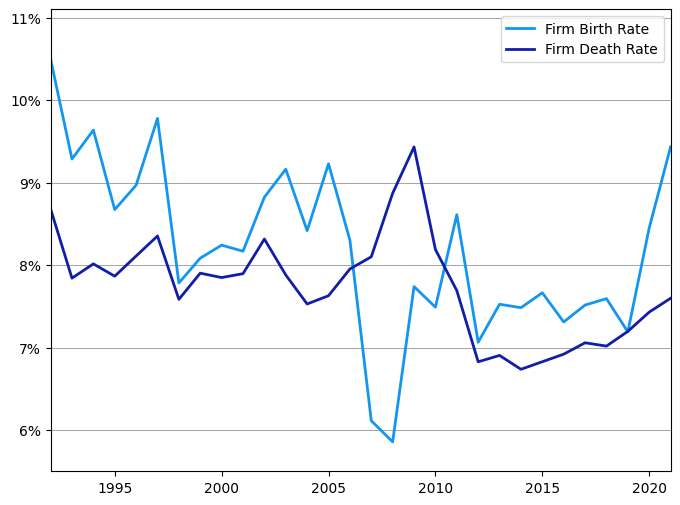

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df['Year'], df['birth_rate'], label='Firm Birth Rate', color='#1396f0', linewidth=2)
ax.plot(df['Year'], df['death_rate'], label='Firm Death Rate', color='#111fA8', linewidth=2)

ax.set_xlim(1992, 2021)
ax.set_ylim(5.5, 11.1)
ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.5)

# format the y ticks to have a percentage sign
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))

ax.legend()

In [50]:
# plot output weighted birth and death rates
plot_df = data[['NAICS', 'Year', 'job_reallocation_rate', 'output_share']].copy()
plot_df['reallocation_rate'] = plot_df['job_reallocation_rate'] * plot_df['output_share']
df = plot_df[['Year', 'reallocation_rate']].groupby(['Year']).sum().reset_index()
df['reallocation_rate'] = df['reallocation_rate'] * 100
df['reallocation_rate_5year'] = df['reallocation_rate'].rolling(5).mean()
df = df[df['Year'] < 2022]
df = df[df['Year'] > 1991]

Text(0.5, 1.0, 'Declining Business Dynamism in the US')

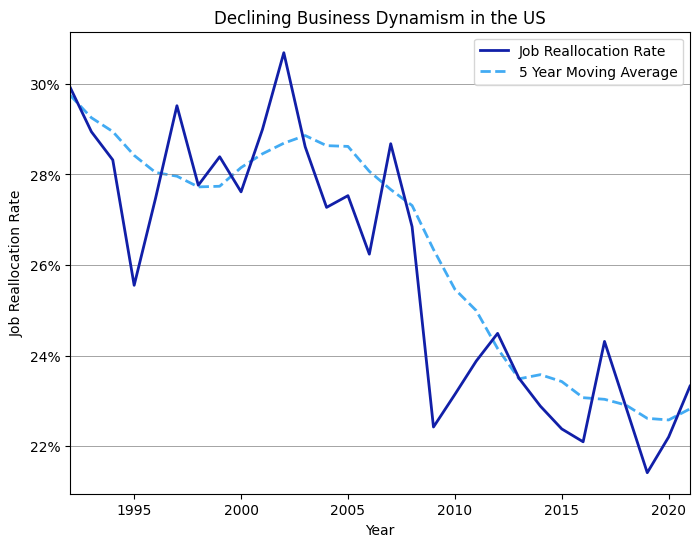

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df['Year'], df['reallocation_rate'],
        label='Job Reallocation Rate',
        color='#111fA8', linewidth=2)

ax.plot(df['Year'], df['reallocation_rate_5year'],
        label='5 Year Moving Average',
        color='#1396f0', linewidth=2, zorder=-10,
        alpha=0.8, linestyle='--')

ax.set_xlim(1992, 2021)
ax.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.5)

# format the y ticks to have a percentage sign
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))

ax.legend()

ax.set_xlabel('Year')
ax.set_ylabel('Job Reallocation Rate')
ax.set_title('Declining Business Dynamism in the US')

## Has there been a slow down in productivity growth?

### Aggregate level

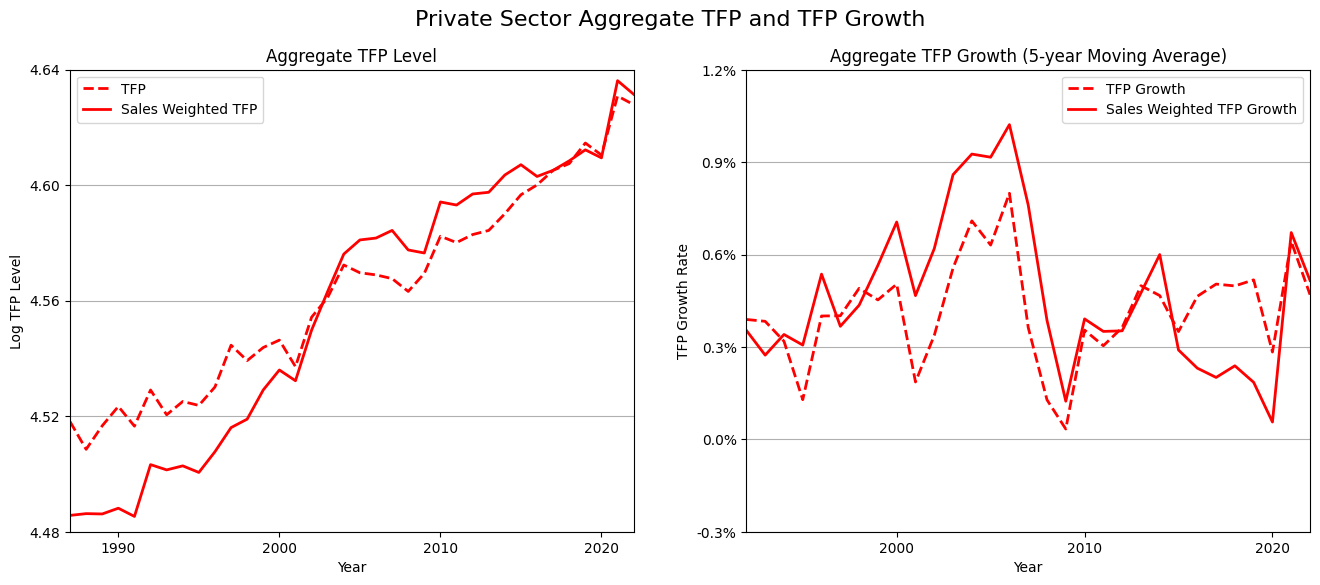

In [52]:
df = data[["Year", "NAICS", "TFP", "TFP_growth", "output_share"]]

aggregate_tfp = df.groupby('Year').agg(
    TFP=('TFP', 'mean'),
).reset_index()

aggregate_tfp["weighted_TFP"] = df.groupby('Year').apply(
    lambda x: np.average(x['TFP'], weights=x['output_share']),
    include_groups=False
).reset_index(drop=True)

aggregate_tfp_growth = df.groupby('Year').agg(
    TFP_growth=('TFP_growth', 'mean'),
).reset_index()

aggregate_tfp_growth["weighted_TFP_growth"] = df.groupby('Year').apply(
    lambda x: np.average(x['TFP_growth'], weights=x['output_share']),
    include_groups=False
).reset_index(drop=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Private Sector Aggregate TFP and TFP Growth', fontsize=16)

ax1.plot(aggregate_tfp['Year'], np.log(aggregate_tfp['TFP']), 'r--', label='TFP', linewidth=2)
ax1.plot(aggregate_tfp['Year'], np.log(aggregate_tfp['weighted_TFP']), 'r-', label='Sales Weighted TFP', linewidth=2)

ax1.set_xlabel('Year')
ax1.set_ylabel('Log TFP Level')
ax1.set_title('Aggregate TFP Level')
ax1.legend()

ax1.set_ylim(4.48, 4.64)
ax1.set_xlim(min(aggregate_tfp['Year']), max(aggregate_tfp['Year']))
ax1.grid(True, axis='y', linestyle='-', alpha=1)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.04))

ax2.plot(aggregate_tfp_growth['Year'], (aggregate_tfp_growth['TFP_growth'].rolling(5, min_periods=5).mean() * 100), 'r--', label='TFP Growth', linewidth=2)
ax2.plot(aggregate_tfp_growth['Year'], (aggregate_tfp_growth['weighted_TFP_growth'].rolling(5, min_periods=5).mean() * 100), 'r-', label='Sales Weighted TFP Growth', linewidth=2)

ax2.set_xlabel('Year')
ax2.set_ylabel('TFP Growth Rate')
ax2.set_title('Aggregate TFP Growth (5-year Moving Average)')
ax2.legend()
ax2.grid(True, axis='y', linestyle='-', alpha=1)

ax2.set_xlim(1992, 2022)
ax2.set_ylim(-0.05, 1.1)

ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.3))

yticks = ax2.get_yticks()
ax2.set_yticks(yticks)
ax2.set_yticklabels([f'{round(tick,2)}%' for tick in yticks])

plt.show()

### Sectoral level

In [53]:
# group the data by NAICS industry, determine the change in tfp_growth from 1988 to 2022
df = data[["NAICS", "Industry", "Year", "TFP_growth"]].copy()

To reduce the volatility of the data, we will use a 5 year moving average to analyse the trends in productivity growth. This is because, annual data is subject to idiosyncratic shocks and is also vulnerable to business cycles. The 5 year moving average smooths out these shocks and cycles, allowing us to see the underlying trend in productivity growth.

In [54]:
df["TFP_growth_5yr"] = df.groupby("NAICS")["TFP_growth"].transform(
    lambda x: x.rolling(5, min_periods=5).mean()
)

average_growth = df[["NAICS", "TFP_growth"]].groupby("NAICS").mean()
average_growth.sort_values("TFP_growth", ascending=False, inplace=True)
average_growth

,TFP_growth
NAICS,
21,0.012906
11,0.011275
51,0.009996
42,0.009769
22,0.008409
MN,0.008137
54,0.007498
56,0.004829
72,0.004161


## Is there a relationship between productivity growth and creative destruction?

Here I will use a panel regression that includes industry and time fixed effects. The panel regression will allow us to control for unobserved heterogeneity across industries and time periods, which can help us isolate the effect of creative destruction on productivity growth. The fixed effects will also help us control for any time-invariant characteristics of the industries that may be correlated with productivity growth.

In [55]:
df = data.copy()
df.dropna(inplace=True)

df = df.set_index(['NAICS', 'Year'])

exog_vars = ['firm_death_rate', 'firm_birth_rate', 'job_reallocation_rate']
exog = df[exog_vars]
exog = sm.add_constant(exog)
dependent = df['TFP_growth']

model = PanelOLS(dependent, 
                exog, 
                entity_effects=True,  # NAICS fixed effects
                time_effects=True)    # Year fixed effects

results = model.fit()

results.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
const,-0.0016,0.0146,-0.1093,0.9130,-0.0304,0.0272
firm_death_rate,0.3323,0.1600,2.0768,0.0383,0.0180,0.6467
firm_birth_rate,-0.0003,0.0005,-0.6883,0.4916,-0.0013,0.0006
job_reallocation_rate,-0.0748,0.0447,-1.6722,0.0951,-0.1626,0.0131


In [56]:
df = data.copy()
df.dropna(inplace=True)

# Standardize 'output'
scaler = StandardScaler()
df['output'] = scaler.fit_transform(df[['output']])

# Set index after transformation
df = df.set_index(['NAICS', 'Year'])

# Create exogenous vars and model
exog_vars = ['job_reallocation_rate', 'output']
exog = df[exog_vars]
exog = sm.add_constant(exog)
dependent = df['TFP_growth']

model = PanelOLS(dependent, exog, entity_effects=True, time_effects=True)
results = model.fit()

results.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
const,0.0177,0.0118,1.5016,0.1338,-0.0055,0.0408
job_reallocation_rate,-0.0493,0.0424,-1.1631,0.2453,-0.1325,0.0340
output,0.0026,0.0043,0.6070,0.5441,-0.0058,0.0110


In [57]:
df = data.copy()
df.dropna(inplace=True)

# Standardize 'output'
scaler = StandardScaler()
df['output'] = scaler.fit_transform(df[['output']])

# Set index after transformation
df = df.set_index(['NAICS', 'Year'])

# Create exogenous vars and model
exog_vars = ['firm_death_rate', 'firm_birth_rate', 'job_reallocation_rate', 'output']
exog = df[exog_vars]
exog = sm.add_constant(exog)
dependent = df['TFP_growth']

model = PanelOLS(dependent, exog, entity_effects=True, time_effects=True)
results = model.fit()

# Export results to CSV
results_html = results.summary.tables[1].as_html()
results_df = pd.read_html(StringIO(results_html), header=0, index_col=0)[0]
results_df.to_csv('../figs/table1.csv')

## Productivity and markup dispersion

In [58]:
df = pd.read_csv("../data/markup_and_productivity.csv")

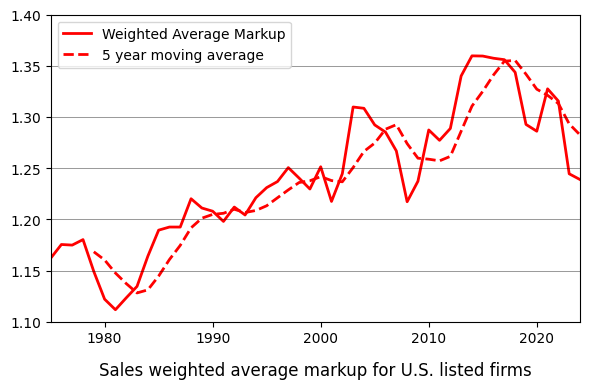

In [59]:
# Calculate weighted average markup by year (weighted by sales)
weighted_avg_markup = df.groupby('year').apply(
    lambda x: (x['markup'] * x['sale']).sum() / x['sale'].sum(),
    include_groups=False
)

# reset index and call column 'weighted_avg_markup'
weighted_avg_markup = weighted_avg_markup.reset_index(name='weighted_avg_markup')

plot_df = weighted_avg_markup[weighted_avg_markup['year'] >= 1975].copy()

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(plot_df['year'], plot_df['weighted_avg_markup'], 'r-', label='Weighted Average Markup', linewidth=2)
ax.plot(plot_df['year'], plot_df['weighted_avg_markup'].rolling(5, min_periods=5).mean(), 'r--', label="5 year moving average",linewidth=2,)

ax.set_ylim(1.1, 1.4)
ax.set_xlim(min(plot_df['year']), max(plot_df['year']))
ax.grid(True, axis='y', linestyle='-', alpha=0.2)
ax.legend(loc='upper left')

# Add horizontal lines at specific y-values
ax.axhline(y=1.15, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
ax.axhline(y=1.20, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
ax.axhline(y=1.25, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
ax.axhline(y=1.30, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
ax.axhline(y=1.35, color='black', linestyle='-', alpha=0.5, linewidth=0.5) 

# Add labels and title
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.set_title('Sales weighted average markup for U.S. listed firms', fontsize=12, loc='center', y=-0.2)

# Add source note
# fig.text(0.5, -0.05, '(Compustat data, estimates from De Loecker, Eeckhout, Unger 2020)', 
#            ha='center', fontsize=10)

# Format x-axis with decades
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

fig.tight_layout()

plt.show()

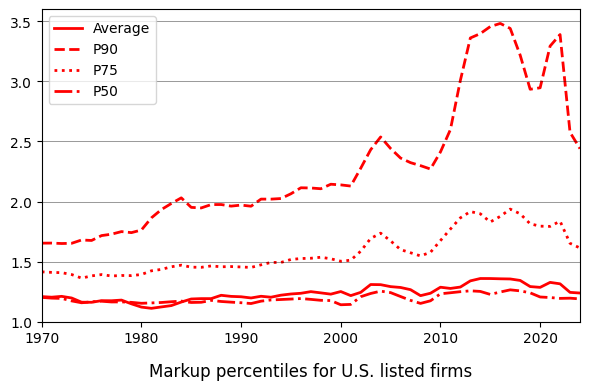

In [60]:
plot_df = df[df['year'] >= 1970].copy()

years = []
p50_values = []
p75_values = []
p90_values = []
weighted_avgs = []

# Group by year and calculate percentiles and sales-weighted average markup
for year, group_data in plot_df.groupby('year'):
    years.append(year)
    
    # Calculate percentiles of markup
    p50 = np.percentile(group_data['markup'], 50)
    p75 = np.percentile(group_data['markup'], 75)
    p90 = np.percentile(group_data['markup'], 90)
    
    p50_values.append(p50)
    p75_values.append(p75)
    p90_values.append(p90)
    
    # Calculate sales-weighted average markup
    total_sales = group_data['sale'].sum()
    weighted_markup = sum(group_data['markup'] * group_data['sale']) / total_sales
    weighted_avgs.append(weighted_markup)

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(years, weighted_avgs, 'r-', linewidth=2, label='Average')
ax.plot(years, p90_values, 'r--', linewidth=2, label='P90')
ax.plot(years, p75_values, 'r:', linewidth=2, label='P75')
ax.plot(years, p50_values, 'r-.', linewidth=2, label='P50')

# Configure plot
ax.set_ylim(1, 3.6)
ax.set_xlim(min(years), max(years))
ax.grid(True, axis='y', linestyle='-', alpha=0.2)
ax.legend(loc='upper left')

# Add horizontal lines at specific y-values
ax.axhline(y=1.0, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
ax.axhline(y=1.5, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
ax.axhline(y=2.0, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
ax.axhline(y=2.5, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
ax.axhline(y=3.0, color='black', linestyle='-', alpha=0.5, linewidth=0.5)
ax.axhline(y=3.5, color='black', linestyle='-', alpha=0.5, linewidth=0.5)

# Add labels and title
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.set_title('Markup percentiles for U.S. listed firms', fontsize=12, loc='center', y=-0.2)

# Add source note
# fig.text(0.5, -0.05, '(Compustat data, estimates from De Loecker, Eeckhout, Unger 2020)', 
#            ha='center', fontsize=10)

# Format x-axis with decades
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

fig.tight_layout()

plt.show()

/Users/oliver/.pyenv/versions/3.13.0/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/oliver/.pyenv/versions/3.13.0/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


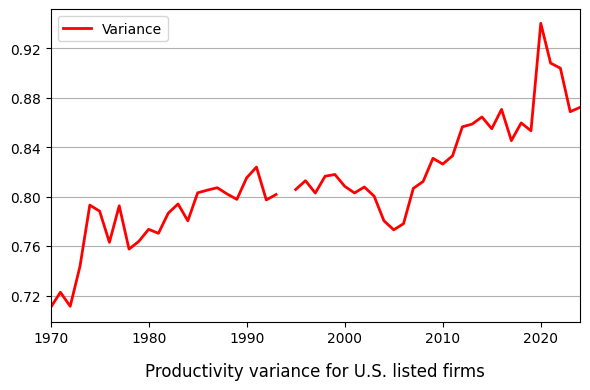

In [62]:
# group by year and calculate the variance of 'a'
plot_df['log_a'] = np.log(plot_df['a'])

variance_by_year = plot_df.groupby('year')['log_a'].std()

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(variance_by_year.index, variance_by_year, 'r-', label='Variance', linewidth=2)

ax.set_xlim(min(plot_df['year']), max(plot_df['year']))
ax.grid(True, axis='y', linestyle='-', alpha=1)
ax.legend(loc='upper left')

# Add labels and title
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.set_title('Productivity variance for U.S. listed firms', fontsize=12, loc='center', y=-0.2)

# Add source note
# fig.text(0.5, -0.05, '(Compustat data, estimates from De Loecker, Eeckhout, Unger 2020)', 
#            ha='center', fontsize=10)

# Format x-axis with decades
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.04))

fig.tight_layout()

plt.show()

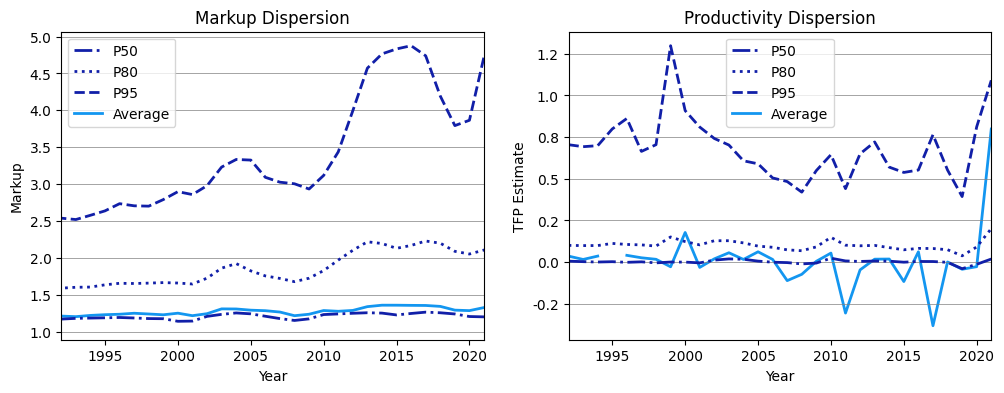

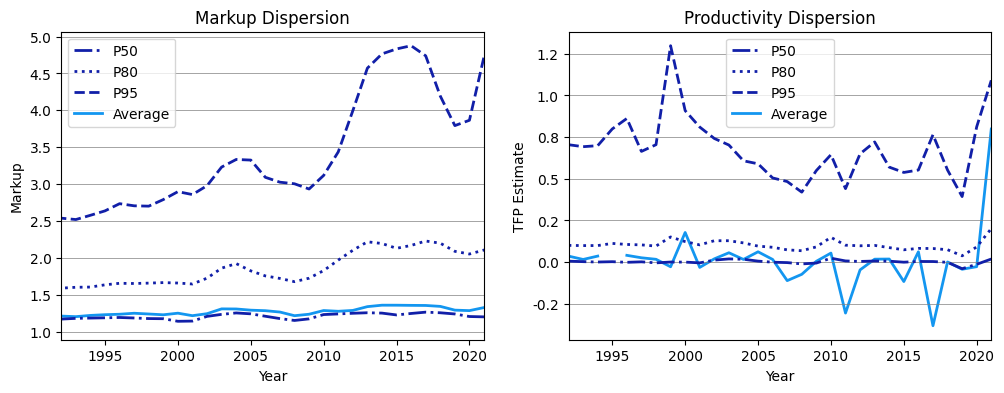

In [68]:
def figure2():
    
    data = pd.read_csv("../data/markup_and_productivity.csv")
    
    # Markup dispersion
    markup_df = data[(data['year'] > 1991) & data['year'] < 2022].copy()

    years = []
    p50_values = []
    p80_values = []
    p95_values = []
    weighted_avgs = []

    # Group by year and calculate percentiles and sales-weighted average markup
    for year, group_data in markup_df.groupby('year'):
        years.append(year)

        # Calculate percentiles of markup
        p50 = np.percentile(group_data['markup'], 50)
        p80 = np.percentile(group_data['markup'], 80)
        p95 = np.percentile(group_data['markup'], 95)

        p50_values.append(p50)
        p80_values.append(p80)
        p95_values.append(p95)

        # Calculate sales-weighted average markup
        total_sales = group_data['sale'].sum()
        weighted_markup = sum(group_data['markup'] * group_data['sale']) / total_sales
        weighted_avgs.append(weighted_markup)
        
    markup_df = pd.DataFrame({
        'year': years,
        'p50': p50_values,
        'p80': p80_values,
        'p95': p95_values,
        'weighted_avg': weighted_avgs
    })
    
    # Productivity dispersion
    productivity_df = data.copy()
    
    productivity_df['a_growth'] = (productivity_df['a'] - productivity_df['a'].shift(1)) / productivity_df['a'].shift(1)
    productivity_df = productivity_df[(data['year'] > 1991) & (data['year'] < 2022)]

    years = []
    p50_values = []
    p80_values = []
    p95_values = []
    weighted_avgs = []

    # Group by year and calculate percentiles and sales-weighted average markup
    for year, group_data in productivity_df.groupby('year'):
        years.append(year)

        # Calculate percentiles of markup
        p50 = np.percentile(group_data['a_growth'], 50)
        p80 = np.percentile(group_data['a_growth'], 80)
        p95 = np.percentile(group_data['a_growth'], 95)

        p50_values.append(p50)
        p80_values.append(p80)
        p95_values.append(p95)

        # Calculate sales-weighted average markup
        total_sales = group_data['sale'].sum()
        weighted_markup = sum(group_data['a_growth'] * group_data['sale']) / total_sales
        weighted_avgs.append(weighted_markup)
        
    productivity_df = pd.DataFrame({
        'year': years,
        'p50': p50_values,
        'p80': p80_values,
        'p95': p95_values,
        'weighted_avg': weighted_avgs
    })
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Markup Dispersion Plot
    ax1.plot(markup_df['year'], markup_df['p50'],
            label='P50',
            color='#111fA8', linewidth=2,
            linestyle='-.')
    
    ax1.plot(markup_df['year'], markup_df['p80'],
            label='P80',
            color='#111fA8', linewidth=2,
            linestyle=':')
    
    ax1.plot(markup_df['year'], markup_df['p95'],
            label='P95',
            color='#111fA8', linewidth=2,
            linestyle='--')

    ax1.plot(markup_df['year'], markup_df['weighted_avg'],
            label='Average',
            color='#1396f0', linewidth=2, zorder=-10)

    ax1.set_xlim(1992, 2021)
    ax1.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.5)

    # format the y ticks to have a percentage sign
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.1f}'.format(x)))

    ax1.legend()

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Markup')
    ax1.set_title('Markup Dispersion')
    
    # Productivity Dispersion Plot
    ax2.plot(productivity_df['year'], productivity_df['p50'],
            label='P50',
            color='#111fA8', linewidth=2,
            linestyle='-.')
    
    ax2.plot(productivity_df['year'], productivity_df['p80'],
            label='P80',
            color='#111fA8', linewidth=2,
            linestyle=':')
    
    ax2.plot(productivity_df['year'], productivity_df['p95'],
            label='P95',
            color='#111fA8', linewidth=2,
            linestyle='--')

    ax2.plot(productivity_df['year'], productivity_df['weighted_avg'],
            label='Average',
            color='#1396f0', linewidth=2, zorder=-10)

    ax2.set_xlim(1992, 2021)
    ax2.grid(visible=True, which='both', axis='y', color='gray', linewidth=0.5)

    # format the y ticks to have a percentage sign
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.1f}'.format(x)))

    ax2.legend()

    ax2.set_xlabel('Year')
    ax2.set_ylabel('TFP Estimate')
    ax2.set_title('Productivity Dispersion')
    
    return fig

fig = figure2()
fig